In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [9]:
# 데이터 로드
file = '../data_final/Train_data.csv'
data = pd.read_csv(file)
data

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,69.6,189,67.2,3.01,67.1
1,69.8,189,67.2,3.01,67.0
2,69.7,189,67.9,3.08,65.9
3,69.7,189,67.8,3.08,65.9
4,69.7,189,67.8,3.08,65.9
...,...,...,...,...,...
198223,69.6,184,66.5,0.00,67.6
198224,69.5,184,66.6,0.00,67.7
198225,69.4,184,66.5,0.00,67.7
198226,69.4,184,66.4,0.00,67.8


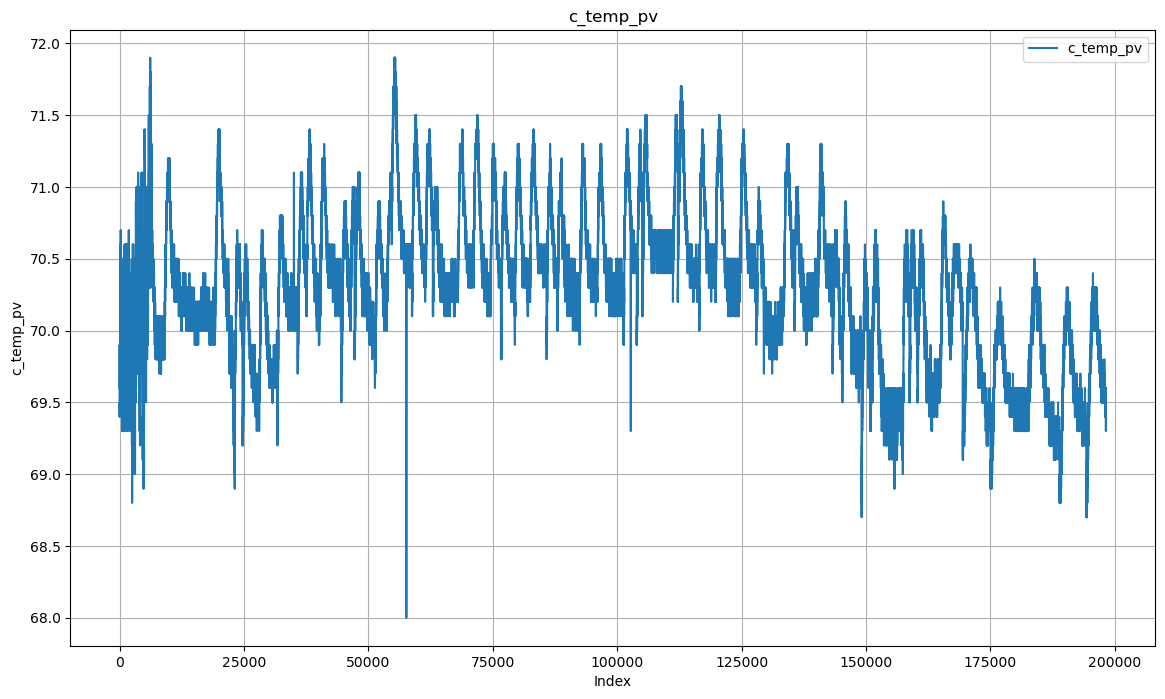

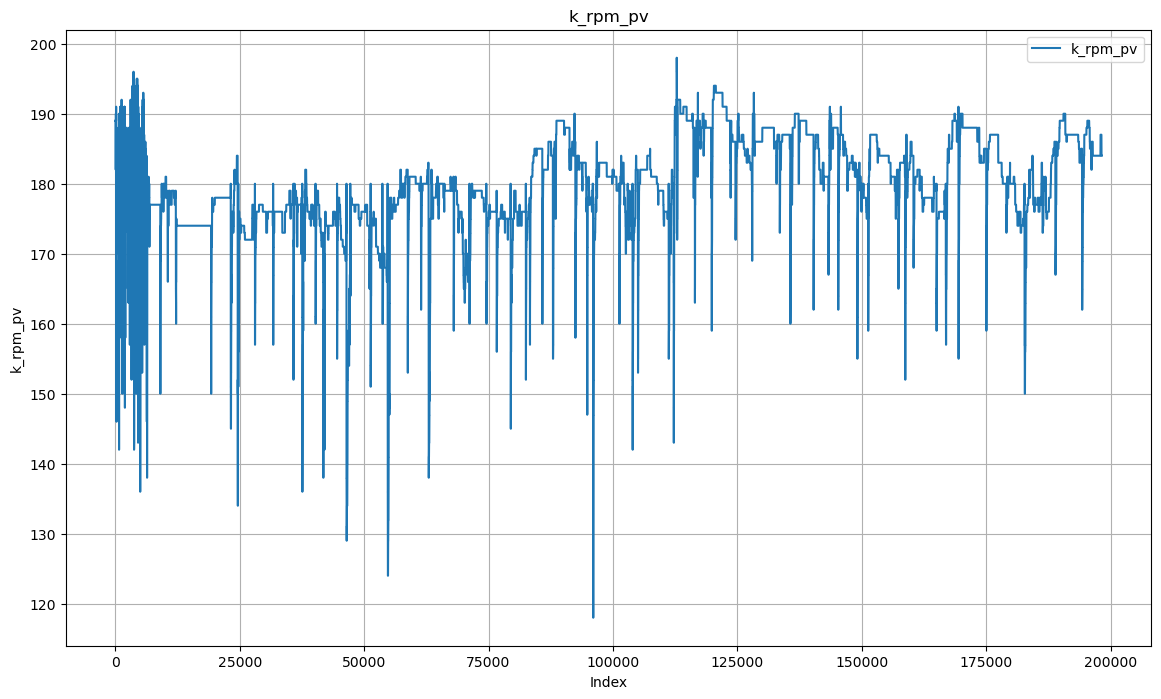

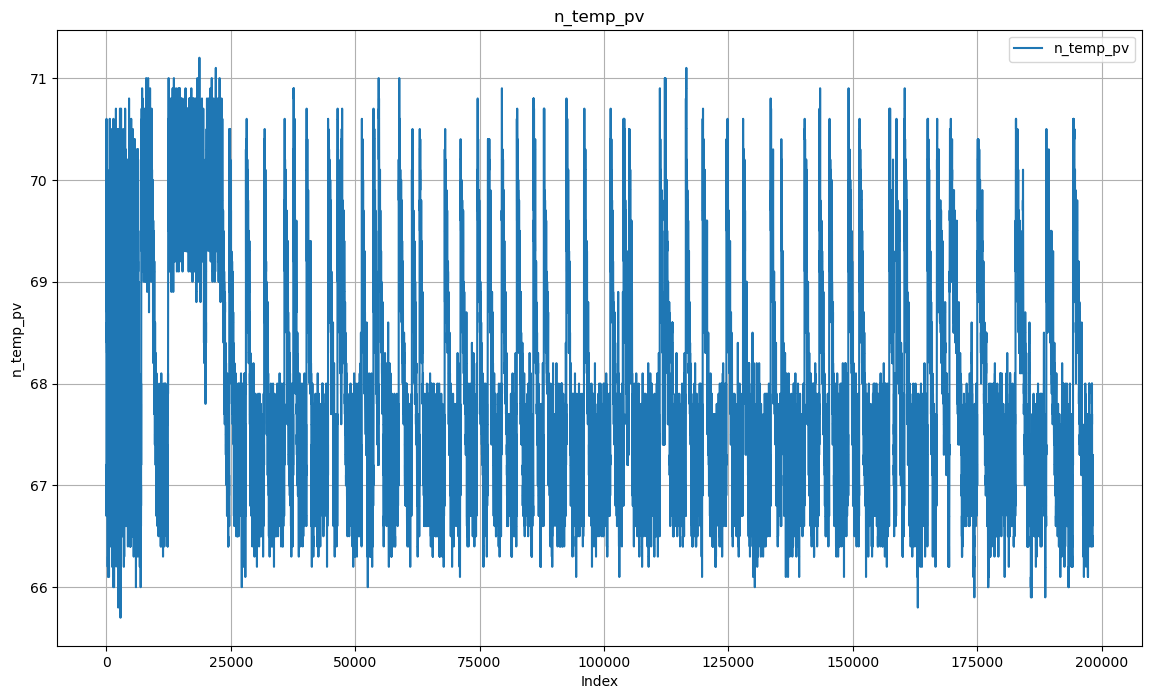

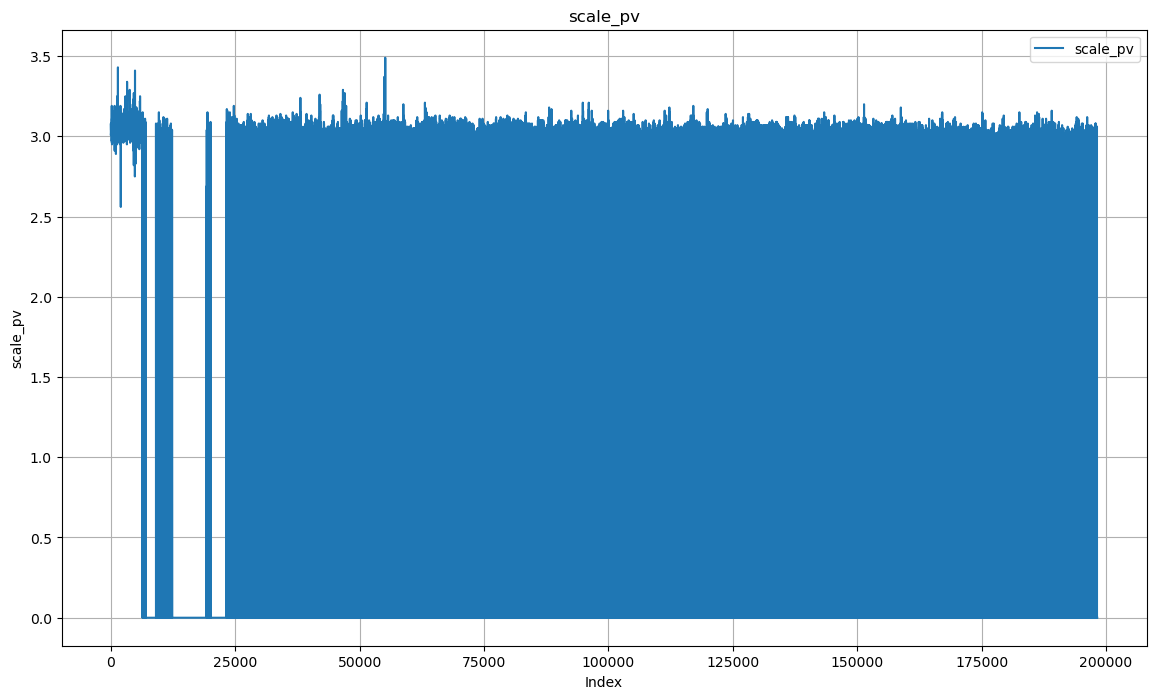

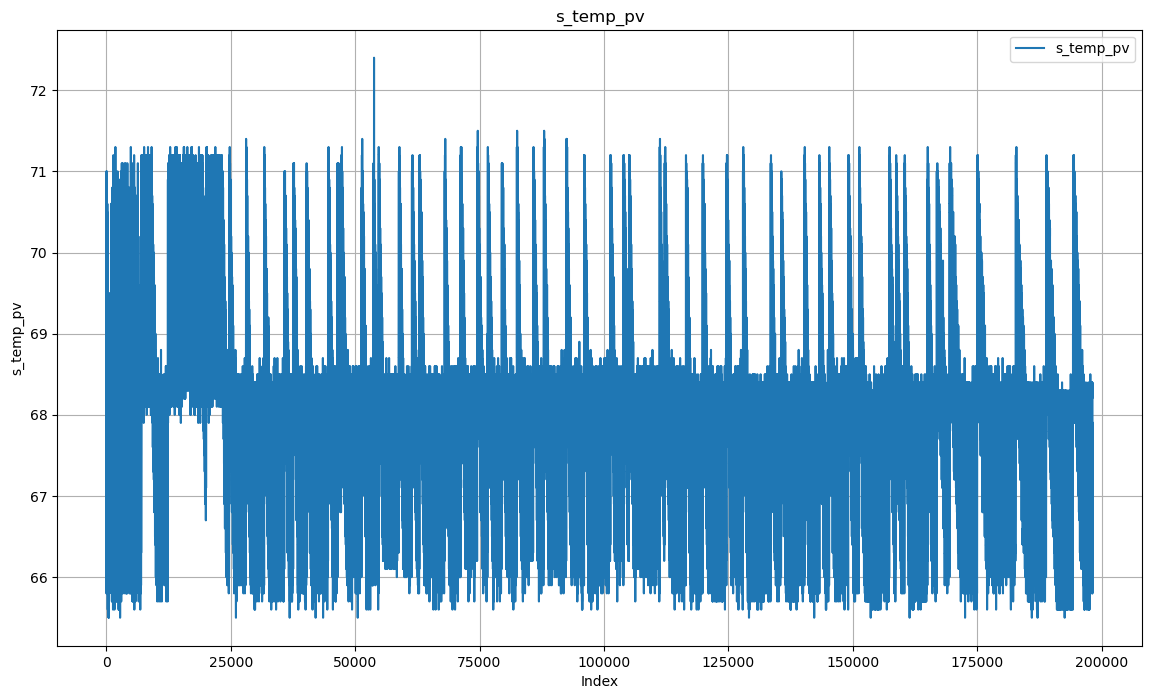

In [10]:
# 각 컬럼별 그래프 그리기
for column in data.columns:
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data[column], label=column)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
data = data[(data['scale_pv'] > 2) & (data['scale_pv'] < 4)]

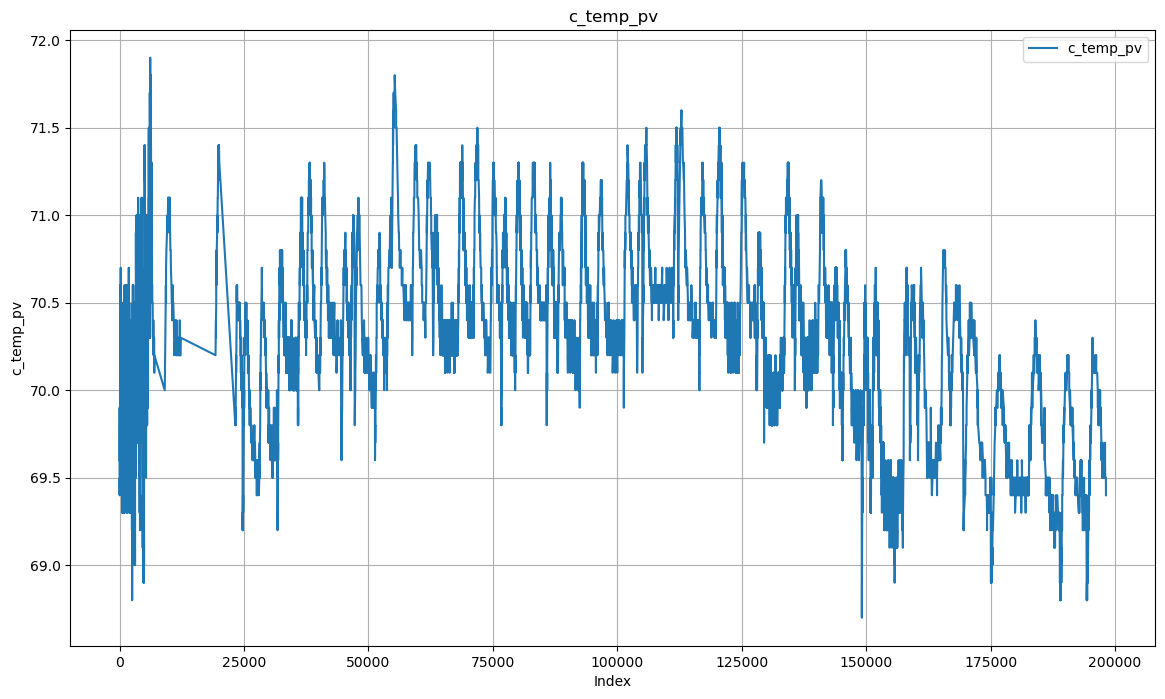

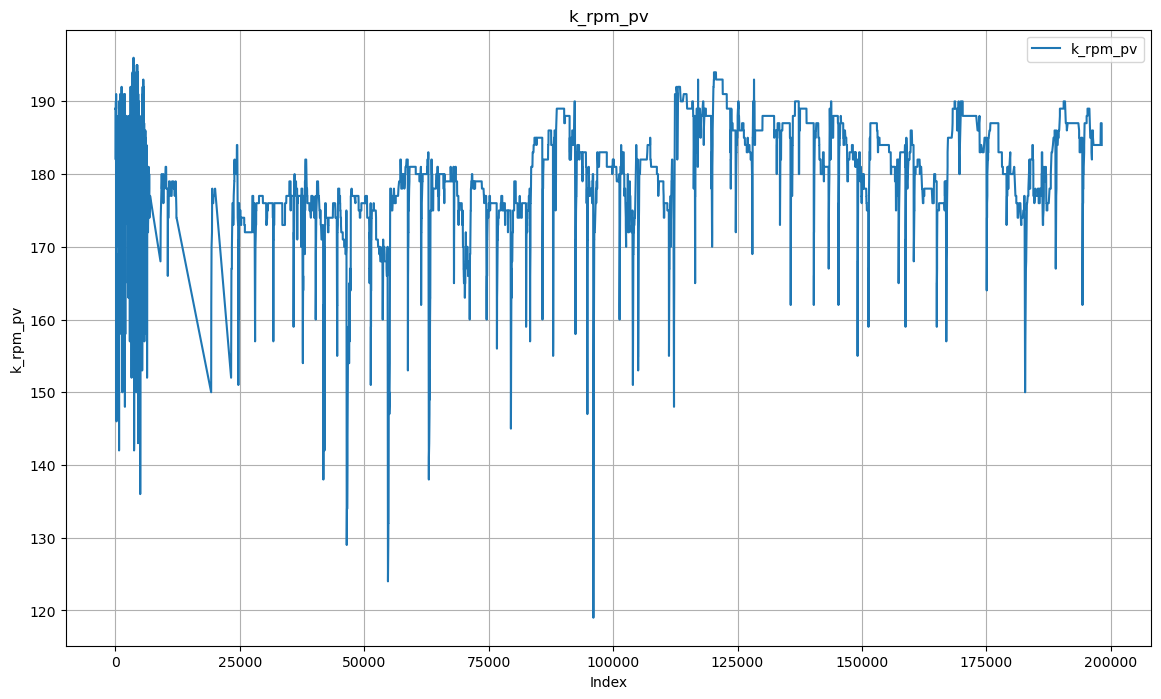

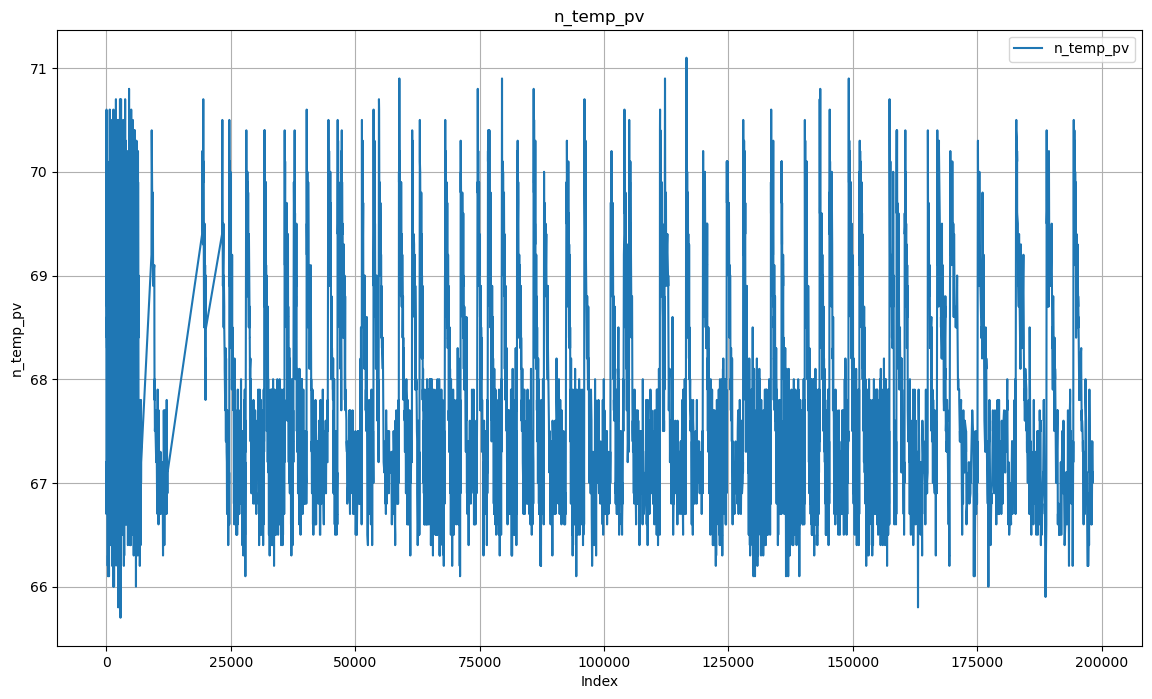

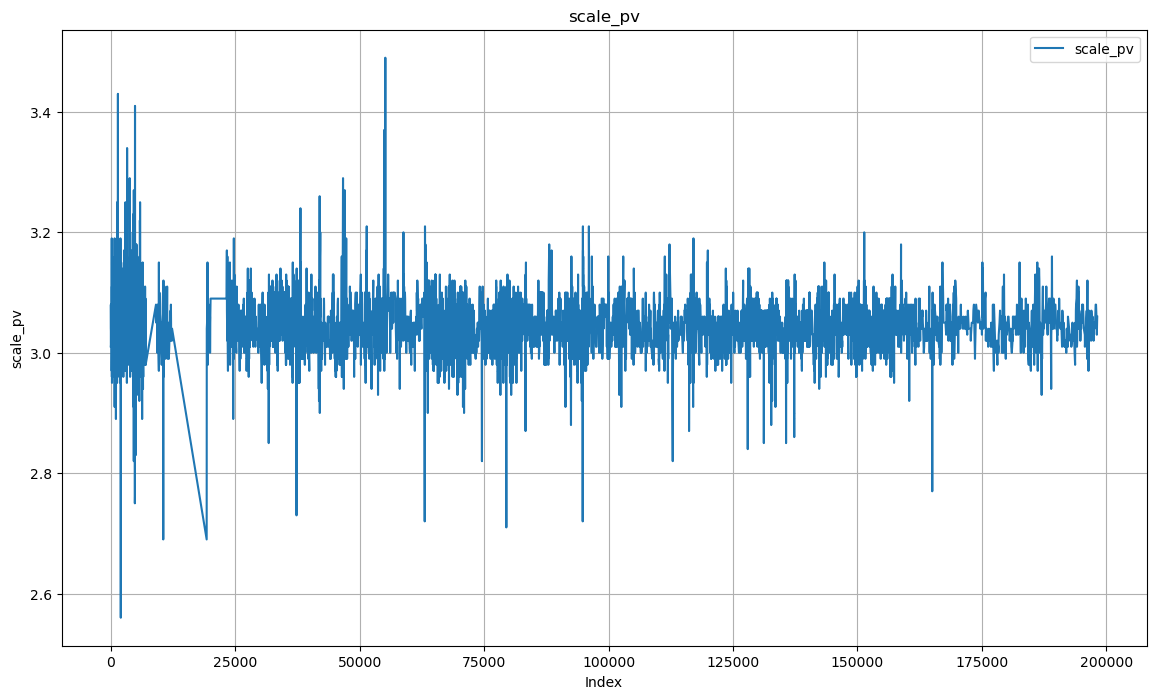

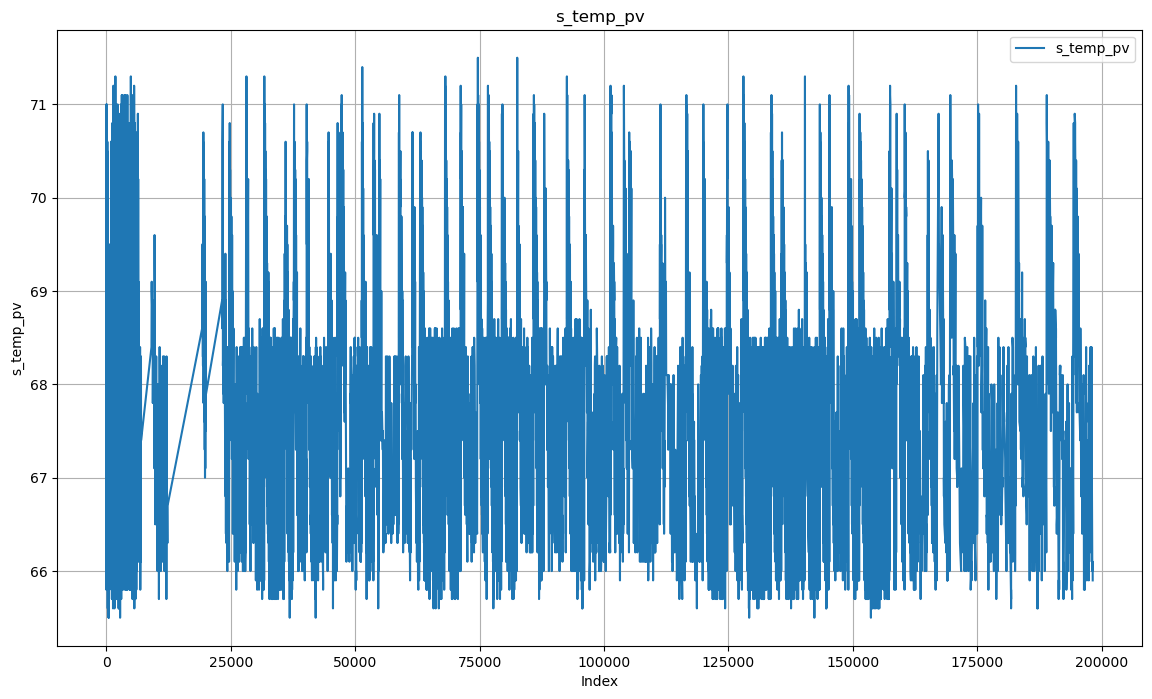

In [12]:
# 각 컬럼별 그래프 그리기
for column in data.columns:
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data[column], label=column)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# 중복값 제거
data.drop_duplicates(inplace=True)

C:\Users\KDP\AppData\Local\Temp\ipykernel_23920\3147107725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [15]:
# 피처와 타겟 분리
X = data.drop(columns=['scale_pv'])
y = data['scale_pv']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 타겟 스케일링
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))  # 여기서 타겟 데이터를 스케일링합니다.
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))  # 동일한 스케일러를 사용하여 테스트 타겟 데이터를 스케일링합니다.

In [17]:
# 모델 학습 및 평가 함수
def train_and_evaluate_model(model, X_train, X_test, y_train_scaled, y_test_scaled, target_scaler):
    model.fit(X_train, y_train_scaled.ravel())  # 스케일된 타겟 데이터를 사용하여 모델을 학습합니다.
    y_train_pred_scaled = model.predict(X_train)
    y_test_pred_scaled = model.predict(X_test)
    
    # 역스케일링
    y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))  # 예측된 값을 역스케일링합니다.
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    y_train_original = target_scaler.inverse_transform(y_train_scaled)  # 원본 스케일의 타겟 데이터를 얻습니다.
    y_test_original = target_scaler.inverse_transform(y_test_scaled)
    
    train_mae = mean_absolute_error(y_train_original, y_train_pred)
    test_mae = mean_absolute_error(y_test_original, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred)
    
    return train_mae, test_mae, train_mape, test_mape, y_train_pred, y_test_pred

In [18]:
# 모델 학습 및 평가

# Multiple Regression
lr_model = LinearRegression()
lr_train_mae, lr_test_mae, lr_train_mape, lr_test_mape, lr_y_train_pred, lr_y_test_pred = train_and_evaluate_model(lr_model, X_train, X_test, y_train_scaled, y_test_scaled, target_scaler)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_train_mae, rf_test_mae, rf_train_mape, rf_test_mape, rf_y_train_pred, rf_y_test_pred = train_and_evaluate_model(rf_model, X_train, X_test, y_train_scaled, y_test_scaled, target_scaler)

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_train_mae, lgb_test_mae, lgb_train_mape, lgb_test_mape, lgb_y_train_pred, lgb_y_test_pred = train_and_evaluate_model(lgb_model, X_train, X_test, y_train_scaled, y_test_scaled, target_scaler)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 26844, number of used features: 4
[LightGBM] [Info] Start training from score -0.000000


In [19]:
# 결과 출력
print(f"Linear Regression - Train MAE: {lr_train_mae}, Train MAPE: {lr_train_mape*100}")
print(f"Linear Regression - Test MAE: {lr_test_mae}, Test MAPE: {lr_test_mape*100}")
print()
print(f"Random Forest - Train MAE: {rf_train_mae}, Train MAPE: {rf_train_mape*100}")
print(f"Random Forest - Test MAE: {rf_test_mae}, Test MAPE: {rf_test_mape*100}")
print()
print(f"LightGBM - Train MAE: {lgb_train_mae}, Train MAPE: {lgb_train_mape*100}")
print(f"LightGBM - Test MAE: {lgb_test_mae}, Test MAPE: {lgb_test_mape*100}")

Linear Regression - Train MAE: 0.02600662009693537, Train MAPE: 0.8563967117358431
Linear Regression - Test MAE: 0.026538280288540907, Test MAPE: 0.8754376532083852

Random Forest - Train MAE: 0.009563750305463255, Train MAPE: 0.3148454649673872
Random Forest - Test MAE: 0.02256654357135547, Test MAPE: 0.7437031060790384

LightGBM - Train MAE: 0.02316277817519758, Train MAPE: 0.7625622064723384
LightGBM - Test MAE: 0.024342217830352002, Test MAPE: 0.8020034969429981


In [20]:
test_file = '../data_final/Test_data.csv'
test_data = pd.read_csv(test_file)
test_data

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,69.4,180,69.5,0.0,70.3
1,69.4,179,69.4,0.0,70.4
2,69.5,176,69.4,0.0,70.6
3,69.4,173,69.6,0.0,70.7
4,69.5,173,69.4,0.0,70.8
...,...,...,...,...,...
29646,69.7,191,67.6,0.0,67.3
29647,69.8,191,67.5,0.0,67.0
29648,69.7,191,67.4,0.0,66.8
29649,69.7,191,67.3,0.0,66.7


In [21]:
# scale_pv 값이 2초과 4미만인 데이터 선택
test_data_filtered = test_data[(test_data['scale_pv'] > 2) & (test_data['scale_pv'] < 4)]

# 피처와 타겟 분리
X_test_final = test_data_filtered.drop(columns=['scale_pv'])
y_test_final = test_data_filtered['scale_pv']

# 최종 테스트 데이터 예측 및 평가
def final_evaluate_model(model, X_test, y_test_scaled, target_scaler):
    y_test_pred_scaled = model.predict(X_test)
    
    # 역스케일링
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    y_test_original = target_scaler.inverse_transform(y_test_scaled)
    
    test_mae = mean_absolute_error(y_test_original, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred)
    
    return test_mae, test_mape, y_test_pred

# 최종 평가 결과
lr_test_mae_final, lr_test_mape_final, lr_y_test_pred_final = final_evaluate_model(lr_model, X_test_final, target_scaler.transform(y_test_final.values.reshape(-1, 1)), target_scaler)
rf_test_mae_final, rf_test_mape_final, rf_y_test_pred_final = final_evaluate_model(rf_model, X_test_final, target_scaler.transform(y_test_final.values.reshape(-1, 1)), target_scaler)
lgb_test_mae_final, lgb_test_mape_final, lgb_y_test_pred_final = final_evaluate_model(lgb_model, X_test_final, target_scaler.transform(y_test_final.values.reshape(-1, 1)), target_scaler)

print(f"Final Test - Linear Regression MAE: {lr_test_mae_final}, MAPE: {lr_test_mape_final*100}")
print(f"Final Test - Random Forest MAE: {rf_test_mae_final}, MAPE: {rf_test_mape_final*100}")
print(f"Final Test - LightGBM MAE: {lgb_test_mae_final}, MAPE: {lgb_test_mape_final*100}")


Final Test - Linear Regression MAE: 0.02367770578477327, MAPE: 0.7737255505206668
Final Test - Random Forest MAE: 0.02684582776930465, MAPE: 0.879040218227447
Final Test - LightGBM MAE: 0.024231265415283674, MAPE: 0.7930421099630216


In [22]:
# 평가된 데이터 갯수 파악
test_data_filtered

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
33,69.6,168,70.1,3.06,68.0
34,69.5,169,70.1,3.06,68.0
47,69.6,169,70.6,3.16,69.4
48,69.6,173,70.5,3.16,69.5
87,69.6,180,69.3,3.17,68.0
...,...,...,...,...,...
29596,69.8,191,66.5,3.05,66.2
29597,69.8,191,66.4,3.05,66.0
29598,69.8,191,66.4,3.05,66.1
29613,69.8,191,66.8,3.09,66.6


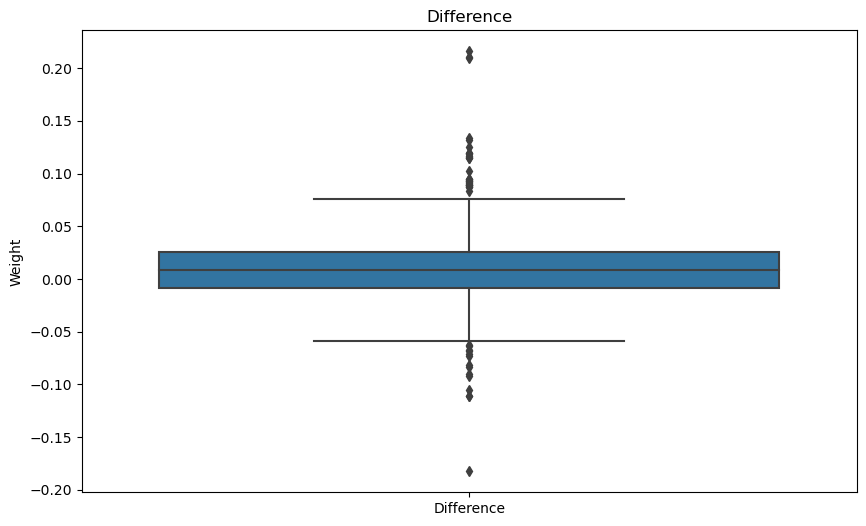

In [23]:
# 예측 값 및 실제 값 데이터 프레임 생성
df_results = pd.DataFrame({
    'Actual': y_test_final,
    'Predicted': lr_y_test_pred_final.flatten()  # flatten()을 사용하여 1차원 배열로 변환
})

# 차이 계산
df_results['Difference'] = df_results['Actual'] - df_results['Predicted']

# 박스플롯 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_results[['Difference']])
plt.title('Difference')
plt.ylabel('Weight')
plt.show()

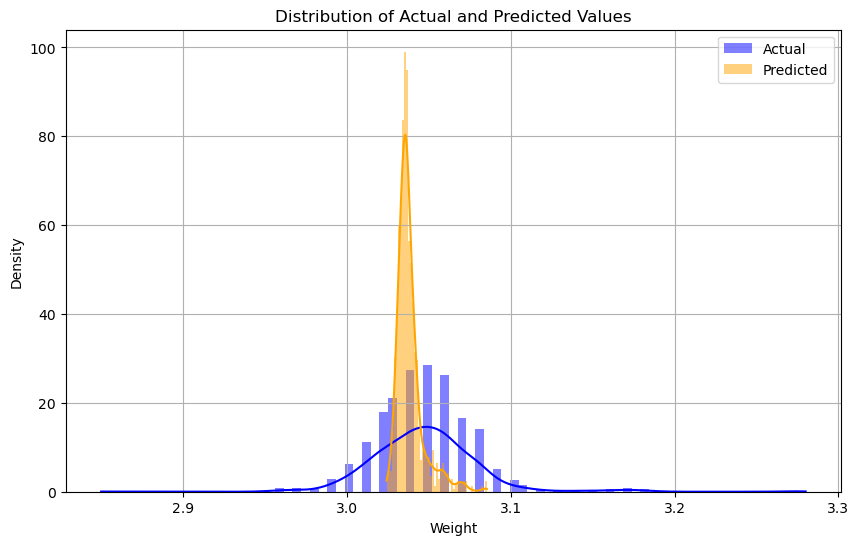

In [24]:
# 히스토그램 및 밀도 플롯 시각화
plt.figure(figsize=(10, 6))
sns.histplot(y_test_final, color='blue', label='Actual', kde=True, stat="density", linewidth=0)
sns.histplot(lr_y_test_pred_final.flatten(), color='orange', label='Predicted', kde=True, stat="density", linewidth=0)
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

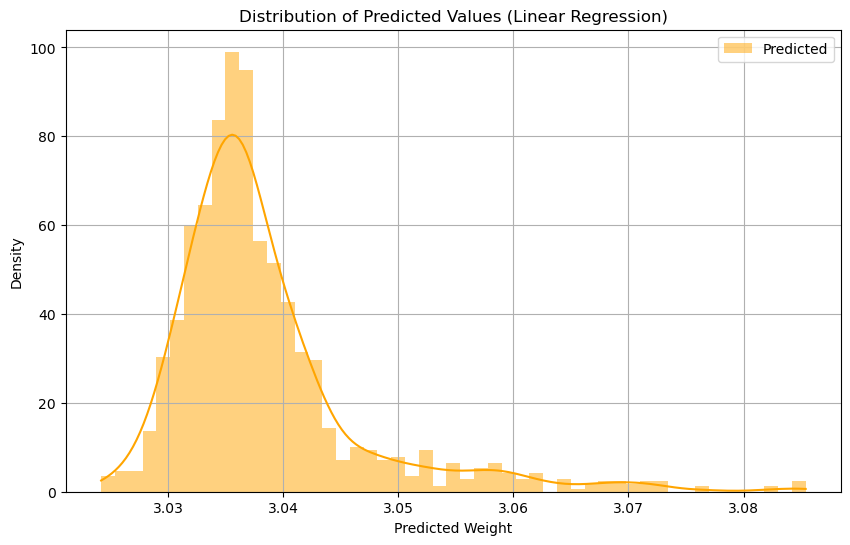

In [25]:
# 예측값 분포 시각화 (Linear Regression)
plt.figure(figsize=(10, 6))
sns.histplot(lr_y_test_pred_final.flatten(), color='orange', label='Predicted', kde=True, stat="density", linewidth=0)
plt.xlabel('Predicted Weight')
plt.ylabel('Density')
plt.title('Distribution of Predicted Values (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()

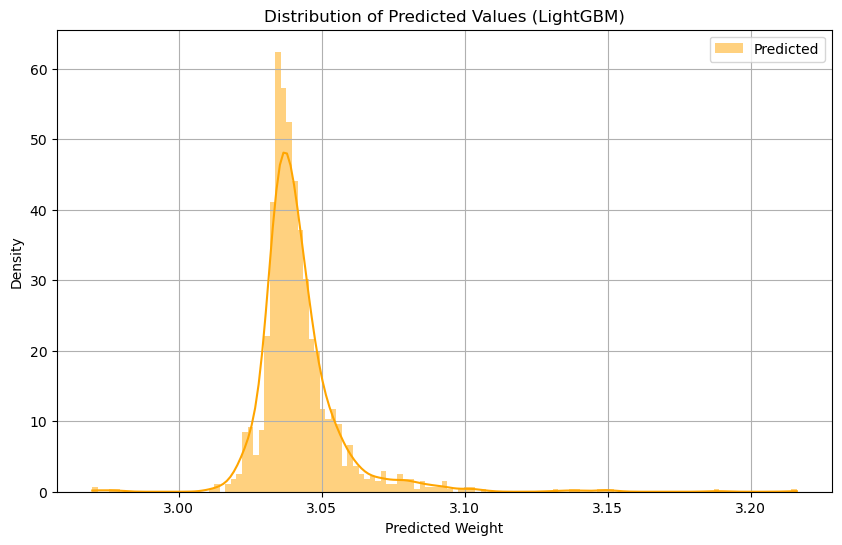

In [26]:
# 예측값 분포 시각화 (LightGBM)
plt.figure(figsize=(10, 6))
sns.histplot(lgb_y_test_pred_final.flatten(), color='orange', label='Predicted', kde=True, stat="density", linewidth=0)
plt.xlabel('Predicted Weight')
plt.ylabel('Density')
plt.title('Distribution of Predicted Values (LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

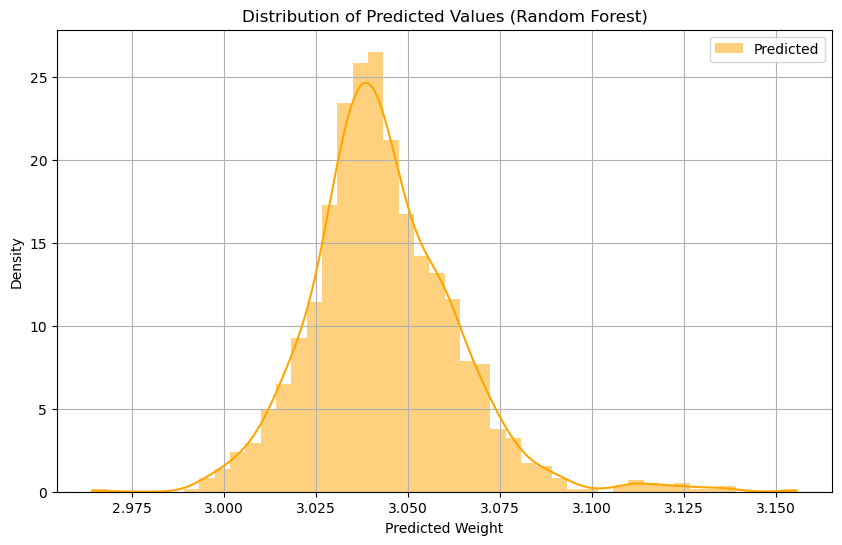

In [27]:
# 예측값 분포 시각화 (Random Forest)
plt.figure(figsize=(10, 6))
sns.histplot(rf_y_test_pred_final.flatten(), color='orange', label='Predicted', kde=True, stat="density", linewidth=0)
plt.xlabel('Predicted Weight')
plt.ylabel('Density')
plt.title('Distribution of Predicted Values (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()